In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

### Import Word2Vec document vectors

In [3]:
wv_matrix = np.load("../../processed_files/w2v_matrix.npy", allow_pickle = True)
df_merged = pickle.load(open("../../processed_files/df_merged.pickle", "rb"))

In [4]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[0, -, m, y, ., c, o, m, , r, e, l, a, t, e, ..."
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[0, 1, 1, 8, 7, ., c, o, m, , i, s, , a, v, ..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[0, 2, 7, ., i, r, , -, , d, n, s, 4, ., i, ..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[f, e, b, r, u, a, r, y, , |, , 2, 0, 1, 4, ..."


In [5]:
df_merged.shape

(12975, 4)

In [6]:
wv_matrix.shape

(12968, 300)

In [7]:
#wv_matrix

## word2vec

In [8]:
from sklearn.preprocessing import normalize
wv_matrix = normalize(wv_matrix, norm='l2', axis=1)

In [9]:
num_clusters = 20
algorithm = 'full'

In [10]:
%%time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0, algorithm=algorithm).fit(wv_matrix)

CPU times: user 30.7 s, sys: 5.54 s, total: 36.2 s
Wall time: 4.41 s


In [11]:
kmeans.labels_

array([ 0,  9, 13, ..., 14,  1, 13], dtype=int32)

In [12]:
index_cluster = zip(range(len(kmeans.labels_)), kmeans.labels_)
index_cluster_dict = dict(index_cluster)
index_cluster_dict[456]

5

In [13]:
cluster_index = list(zip(kmeans.labels_, range(len(kmeans.labels_))))

In [14]:
cluster_list = dict()
for i in range(num_clusters):
    cluster_list[i] = list(filter(lambda row: row[0] == i, cluster_index))

In [15]:
cluster_list[0]

[(0, 0),
 (0, 30),
 (0, 63),
 (0, 123),
 (0, 140),
 (0, 161),
 (0, 167),
 (0, 252),
 (0, 280),
 (0, 311),
 (0, 351),
 (0, 451),
 (0, 463),
 (0, 479),
 (0, 536),
 (0, 568),
 (0, 621),
 (0, 637),
 (0, 638),
 (0, 641),
 (0, 660),
 (0, 719),
 (0, 783),
 (0, 791),
 (0, 881),
 (0, 889),
 (0, 950),
 (0, 995),
 (0, 1072),
 (0, 1108),
 (0, 1128),
 (0, 1141),
 (0, 1155),
 (0, 1163),
 (0, 1166),
 (0, 1172),
 (0, 1179),
 (0, 1191),
 (0, 1303),
 (0, 1304),
 (0, 1381),
 (0, 1399),
 (0, 1401),
 (0, 1409),
 (0, 1509),
 (0, 1510),
 (0, 1539),
 (0, 1637),
 (0, 1668),
 (0, 1689),
 (0, 1691),
 (0, 1716),
 (0, 1762),
 (0, 1812),
 (0, 1816),
 (0, 1846),
 (0, 1859),
 (0, 1892),
 (0, 1917),
 (0, 1958),
 (0, 1989),
 (0, 2004),
 (0, 2007),
 (0, 2048),
 (0, 2065),
 (0, 2070),
 (0, 2075),
 (0, 2091),
 (0, 2107),
 (0, 2116),
 (0, 2126),
 (0, 2139),
 (0, 2168),
 (0, 2183),
 (0, 2227),
 (0, 2238),
 (0, 2254),
 (0, 2281),
 (0, 2327),
 (0, 2349),
 (0, 2356),
 (0, 2407),
 (0, 2409),
 (0, 2487),
 (0, 2519),
 (0, 2553),


In [16]:
print(kmeans.labels_.shape)
print(kmeans.cluster_centers_.shape)

(12968,)
(20, 300)


In [17]:
import statistics

# index is cluster index
def intracluster_similarity(index):
    cluster_centroid = kmeans.cluster_centers_[index]
    dist_list = []
    cluster = cluster_list[index]
    for i in cluster:
        distance = np.linalg.norm(cluster_centroid-wv_matrix[i[1]])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)

    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    
    return avg, variance

In [18]:
intracluster_similarity(0)

(0.4178643036280351, 0.014089499215278975)

In [19]:
# index is cluster / cluster id
def generate_raw_content_cluster_df(index):
    index_list = cluster_list[index]
    index_list = [x[1] for x in index_list]
    cluster_seed = df_merged.loc[index].to_frame().T
    #cluster_df = df_merged.loc[index_list[1:]]
    cluster_df = df_merged.loc[index_list[1:]]
    combined = pd.concat([cluster_seed, cluster_df])
    combined['cluster'] = index
    return combined

In [20]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(1)

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED,cluster
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",1
5,05238.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
6,07153.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
13,11492.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
17,13115.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
18,13392.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
20,14812.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
21,15737.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
77,24870.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
86,29642.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1


In [21]:
avg_list = []
variance_list = []

for i in range(num_clusters):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x1b97ea4588>,
 <a list of 11 Text xticklabel objects>)

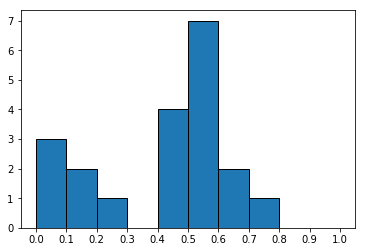

In [22]:
# number of clusters = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [23]:
print(len(avg_list), len(variance_list))

20 20


## Intercluster Similarity

In [24]:
def intercluster_dist():
    indices = range(len(kmeans.cluster_centers_))
    centroid_centroid_distance = {}
    values = []
    for i in indices:
        for j in indices:
            if i < j:
                key = str(i) + "::" + str(j)
                distance = np.linalg.norm(kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j])
                centroid_centroid_distance[key] = distance
                values.append(distance)
    return centroid_centroid_distance, values

## number of clusters = 20

In [25]:
intercluster_distances, values = intercluster_dist()
#print('distances', values)
print('average', np.average(values))

average 0.7429607513030577
